In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbc-full-text-document-classification/bbc_data.csv


In [2]:
df = pd.read_csv('/kaggle/input/bbc-full-text-document-classification/bbc_data.csv')
df.head(10000)

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [3]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import gensim
from gensim.models import Word2Vec

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [4]:
df.loc[0,'data']

'Musicians to tackle US red tape  Musicians groups are to tackle US visa regulations which are blamed for hindering British acts chances of succeeding across the Atlantic.  A singer hoping to perform in the US can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. Groups including the Musicians Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.  Nigel McCune from the Musicians Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.  "The US is the worlds biggest music market, which means something has to be done about the creaky 

In [5]:
df['labels'].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

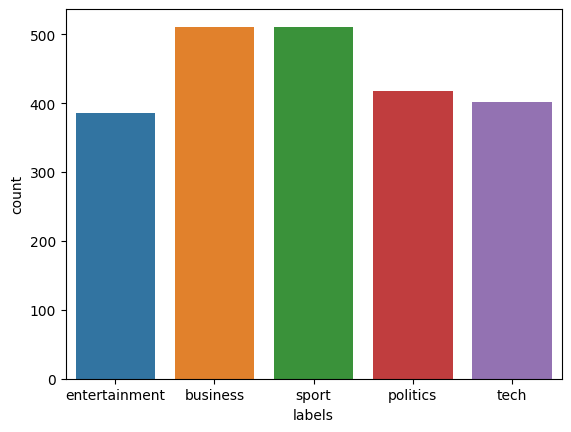

In [6]:
sns.countplot(x = 'labels',data = df)
plt.show()

## **Pre-processing**

In [7]:
data = list(df['data']) #Converting input data to list

In [8]:
data_lower = [a.lower() for a in data] #lower case

In [9]:
tokens = [word_tokenize(a) for a in data_lower] #word tokenize every document in the corpus

In [10]:
sw = stopwords.words('english')
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
tokens = [[w for w in t if w not in sw] for t in tokens] #Removing stopwords

In [12]:
punc = RegexpTokenizer(r'\w+') #Initialize regular expressions tokenizer

In [13]:
#Removing puctuations
tokens = [["".join(punc.tokenize(word)) for word in t if len(punc.tokenize(word)) > 0] for t in tokens]

In [14]:
#Initialize Stemmer
porter = PorterStemmer()
lancaster = LancasterStemmer()

In [15]:
tokens = [[porter.stem(word) for word in t] for t in tokens] #Stemming 

In [16]:
y = df['labels']

In [17]:
clean_data = [" ".join(doc) for doc in tokens]

## Word2Vec for word embedding

In [18]:
clean_data[:1]

['musician tackl us red tape musician group tackl us visa regul blame hinder british act chanc succeed across atlant singer hope perform us expect pay 1300 xc2xa3680 simpli obtain visa group includ musician union call end raw deal face british perform us act face compar expens bureaucraci visit uk promot purpos nigel mccune musician union said british musician disadvantag compar us counterpart sponsor make petit behalf form amount nearli 30 page musician face tougher regul athlet journalist make mistak form risk fiveyear ban thu abil career say mr mccune us world biggest music market mean someth done creaki bureaucraci say mr mccune current situat prevent british act maintain momentum develop us ad musician union stanc endors music manag forum mmf say british artist face uphil struggl succeed us thank tough visa requir also seen impract mmf gener secretari jame seller said imagin orchestra orkney everi member would travel london visa process us market seen holi grail one benchmark succ

In [19]:
model = Word2Vec(tokens, min_count = 2, sg = 1, window = 3, epochs = 20) #Creating word vectors for every word in the corpus

In [20]:
model.wv['journalist'] 

array([ 0.09174771,  0.2739254 , -0.06154114,  0.38640195, -0.211701  ,
       -0.38124356, -0.47346953,  0.07874634,  0.15067188, -0.44155204,
        0.04634648, -0.00338647, -0.15467347,  0.02448644, -0.5715528 ,
        0.05016585, -0.11539923,  0.2215686 ,  0.39553842, -0.4477455 ,
        0.2660909 , -0.01347601,  0.2658389 , -1.2344078 , -0.06208859,
        1.1013414 , -0.10050061,  0.10563032, -0.34372345,  0.5193917 ,
        0.3324607 ,  0.6704717 , -0.18669687, -0.6809634 ,  0.77835065,
        0.4951756 ,  0.43408057, -0.67552483,  0.45794818, -1.1311923 ,
       -0.18808863, -1.0808008 , -0.35360673, -0.3857884 , -0.04413404,
       -0.18390632, -0.19144206, -0.1145611 ,  0.10323571,  0.01841777,
       -0.600315  , -0.37930208, -0.72474337, -0.04762606,  0.07504614,
        0.11916987,  0.24466453, -0.20333168, -0.34584606, -0.07815695,
        0.08893977,  0.09079879, -0.29302028, -0.05623476,  0.22348766,
        0.16809855, -0.12584805, -0.05928193,  0.45189896,  0.52

In [21]:
model.wv.most_similar('journalist')

[('covert', 0.6195148229598999),
 ('yougov', 0.6030336618423462),
 ('privileg', 0.5728667378425598),
 ('contempt', 0.5586951375007629),
 ('serialis', 0.5586596131324768),
 ('speechwrit', 0.5537557005882263),
 ('prematch', 0.5533537864685059),
 ('appleinsidercom', 0.5521729588508606),
 ('telegraph', 0.5486298203468323),
 ('scotsman', 0.5475577116012573)]

In [22]:
#Word vectors for every sentence in the corpus
sentences = [np.mean([model.wv[word] for word in sentence if word in model.wv], axis = 0) for sentence in clean_data]

In [23]:
sentences[:1]

[array([ 0.11131379,  0.33423698, -0.01433905, -0.36608416,  0.03810572,
        -0.02021182, -0.09888846,  0.27670035,  0.07887901, -0.01355606,
        -0.08729669, -0.23755534,  0.2716211 ,  0.62186277, -0.5241147 ,
        -0.0756283 , -0.5616546 , -0.0342936 , -0.05534667, -0.00924473,
        -0.03796307,  0.3298536 , -0.13428926, -0.2518963 , -0.01003838,
        -0.05893267,  0.36557555, -0.0773443 , -0.27241433,  0.0444259 ,
         0.29576004,  0.08287109, -0.22102447, -0.21127754, -0.21435468,
        -0.27771348, -0.05670519,  0.0656731 ,  0.14292674, -0.3876065 ,
         0.15326123, -0.36663353, -0.08135994, -0.48177525,  0.16588792,
        -0.03419543,  0.16611384,  0.36408216, -0.03292025,  0.27399203,
        -0.08290242, -0.69852483, -0.3281451 ,  0.04467904, -0.20186022,
        -0.38026503, -0.06811058, -0.2597194 , -0.27165145, -0.08841837,
         0.23210715,  0.1995183 ,  0.15803623,  0.35625297, -0.03554969,
         0.2108286 , -0.3361423 , -0.19998783,  0.0

In [24]:
X_train, X_test, y_train, y_test = train_test_split(sentences, y, stratify = y, random_state = 42, test_size = 0.2)

In [25]:
X_train[:1]

[array([ 0.12312634,  0.3554995 , -0.02233615, -0.3878629 ,  0.04462171,
        -0.0013602 , -0.1010579 ,  0.28991655,  0.07650281, -0.01984969,
        -0.08417843, -0.23246942,  0.27742323,  0.6353121 , -0.5604567 ,
        -0.07243975, -0.6007716 , -0.02999151, -0.05798867,  0.01240289,
        -0.04193108,  0.36179066, -0.14603154, -0.26972213, -0.00841324,
        -0.0620893 ,  0.38127273, -0.05415433, -0.27676508,  0.04333663,
         0.3045336 ,  0.08694378, -0.2438896 , -0.23424444, -0.2241262 ,
        -0.30137593, -0.04570854,  0.06909383,  0.16819808, -0.40017912,
         0.14256419, -0.390098  , -0.08735001, -0.48472175,  0.18051715,
        -0.02790376,  0.17813765,  0.38825122, -0.04271259,  0.28223062,
        -0.0923301 , -0.74301624, -0.3303707 ,  0.05778801, -0.21409984,
        -0.41708848, -0.08286348, -0.2786095 , -0.27249828, -0.08613958,
         0.25586313,  0.21505857,  0.14507645,  0.3843889 , -0.02532068,
         0.21329014, -0.34762934, -0.21937302,  0.0

## **Random Forest Classifier**

In [26]:

rf_classifier = RandomForestClassifier(random_state = 42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
y_pred = rf_classifier.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5865168539325842


## **Check for any news classification**

In [29]:
def label_model(data) : 
    #x = list(data)
    #lower case
    data = data.lower()
    #tokenize the words
    tokens = word_tokenize(data)
    #stopwords removal
    tokens = [w for w in tokens if w not in sw]
    #punctutation removal
    #tokens = ["".join(punc.tokenize(word)) for word in tokens if len(punc.tokenize(word)) > 0]
    tokens = " ".join(tokens)
    tokens = punc.tokenize(tokens)
    stemmed_tokens = [porter.stem(word) for word in tokens]
    #tokens = [lancaster.stem(t) for t in tokens]
    #joining back the words
    #clean_tokens = " ".join(stemmed_tokens)
    sentences = [model.wv[word] for word in stemmed_tokens if word in model.wv]
    if sentences :
        input_embedding = np.mean(sentences, axis = 0)
    return input_embedding

    

def machine_model(x) :
    embedded_input = label_model(x)
    X = rf_classifier.predict([embedded_input])
    return X
    

In [30]:
machine_model("Google Cloud, in recent times, has been taking multiple steps to establish itself as a pro-Web3 entity. Now, Solana Labs has joined forces with Google Cloud. Through this partnership, the team behind the eco-friendly green blockchain will use the capabilities of Google Cloud to offer its own blockchain-based game development suit to developers. With this, Solana Labs wish to bring the blockchain technology on the forefront of gaming development.")

array(['business'], dtype=object)